## Autoencoder Convolucional SSA - Two layers HH

Continuamos el estudio de la aproximación SSA a primer orden. Entrenamos un modelo convolucional utilizando imágenes de gráficos polares de la sección eficaz en el canal HH - $\sigma_{HH}(\hat{k}_x, \hat{k}_y)$ -, generados por un modelo de dos capas rugosas bajo la aproximación SSA. 

### Generamos los datos


Usamos un modelo numérico para generar nuestros datos. 

In [1]:
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt

import two_rough_layers 

# Parámetros fijos
realizations = 20480

# Generamos los parámetros que vamos a variar aleatoriamente
k0 = 2*pi/.245
d = np.linspace(.1, .7, 50)
ep1, ep2 = np.arange(3, 35), np.arange(3, 35)
s1, s2 = np.linspace(.004, .012, 50), np.linspace(.004, .012, 50)
l1, l2 = 6*s1, 6*s2
theta_i, phi_i = 38.5*np.pi/180, 0 

# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 64)*np.pi / \
    180, np.linspace(0, 360, 64)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

# Sampleo y recorro: generamos un vector aleatorio que contenga los índices de los argumentos
rng = np.random.default_rng()
sigma = np.zeros((realizations, PHI.shape[0], PHI.shape[1]))


for i in range(realizations):
    # Genero una tira de indices aleatorios
    index = rng.integers(50, size=9)
    
    # Armo una tupla con los argumentos de S01     
    args = (k0, THETA, PHI,
            theta_i[index[0]], phi_i[index[1]], 
            ep1[index[2]], ep2[index[3]],
            s1[index[4]], l1[index[5]],
            s2[index[6]], l2[index[7]],
            d[index[8]])

    # Calculo la sección eficaz y agrego ruido
    s_O1 = two_rough_layers.suma_O1(*args)

    # h-pol
    s_hh = s_O1[1, 1]
    s_hh_noise = s_hh #+ np.abs(rng.normal(0, .03*np.std(s_hh), size=PHI.shape))

    # Guardo los resultados en un tensor: primero apilo los tres canales (stack)
    # Cuenta cantidad de NaNs
    cond = np.count_nonzero(np.isnan(s_hh_noise))
    if cond == 0:
        sigma[i, :, :] = s_hh_noise
    else:
        raise ValueError(f'Input contains NaN, infinity or a value too large for {s_hh_noise.dtype}')

# Chequeo el tamaño de los datos
shape = sigma.shape
print(f'Tamaños de los datos originales: {shape}')

Tamaños de los datos originales: (20480, 64, 64)


### Preparamos los datos

Comencemos separando los datos en conjuntos de entrenamiento y testeo. Apliquemos una estandarización de los datos, teniendo en cuenta el IQR.

In [2]:
from sklearn.model_selection import train_test_split

# Chequeo que no haya NaNs
print(f'Cantidad de NaNs en sigma: {np.count_nonzero(np.isnan(sigma))}')

# Separo en conjuntos de entrenamiento y testeo
sigma_train, sigma_test = train_test_split(sigma, test_size=.3)

print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

Cantidad de NaNs en sigma: 0
Tamaño de los datos de entrenamiento: (14336, 64, 64)
Tamaño de los datos de testeo: (6144, 64, 64)


In [3]:
# Robust Scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler().fit(sigma_train.reshape(-1, sigma_train.shape[-1]))

scaled_train = scaler.transform(sigma_train.reshape(-1, sigma_train.shape[-1])).reshape(sigma_train.shape)
scaled_test = scaler.transform(sigma_test.reshape(-1, sigma_test.shape[-1])).reshape(sigma_test.shape)

In [4]:
scaled_train, scaled_test = np.expand_dims(scaled_train, axis=-1), np.expand_dims(scaled_test, axis=-1)

print(f'Tamaño de los datos de entrenamiento: {scaled_train.shape}')
print(f'Tamaño de los datos de testeo: {scaled_test.shape}')

Tamaño de los datos de entrenamiento: (14336, 64, 64, 1)
Tamaño de los datos de testeo: (6144, 64, 64, 1)


#### Visualizo las soluciones generadas

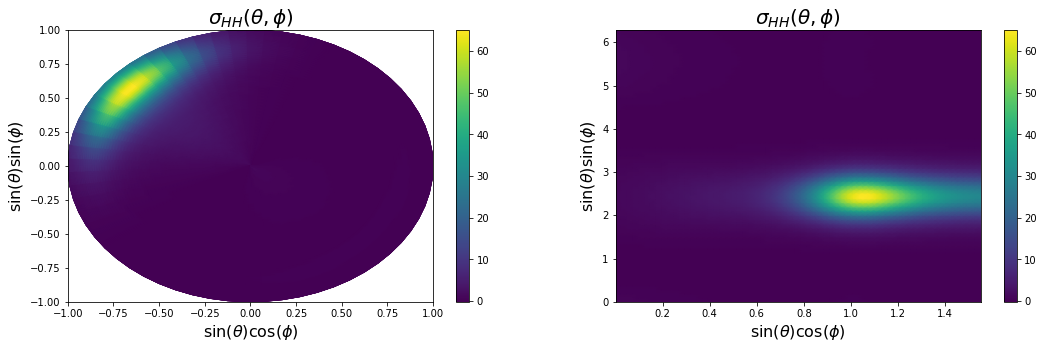

In [5]:
# Elijo una imagen al azar
index = rng.integers(scaled_train.shape[0]) 
img = scaled_train[index, :, :, 0]

fig = plt.figure(figsize=(18, 5))
# Canal HH
ax = plt.subplot(1, 2, 1)
c = ax.pcolormesh(kx, ky, img,
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# grafico cartesiano
ax = plt.subplot(1, 2, 2)
c = ax.pcolormesh(THETA, PHI, img,
                  shading = 'gouraud')
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)


### Definimos el modelo de aprendizaje profundo: Autoencoder Convolucional

Defino un modelo que voy a ir retocando para llegar a que *pueda aprender* los datos generados. Una vez que consiga esto, pasamos a ajustar hyperparámetros.

In [29]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

# Para silenciar los warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

class ConvAutoencoder(Model):
    
    def __init__(self, latent_dim, kernel_init='glorot_uniform'):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (64, 64, 1)), 
                                            layers.Conv2D(4, (6, 6), strides=1, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(16, (5, 5), strides=2, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(32, (4, 4), strides=2, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),

                                            layers.Conv2D(32, (3, 3), strides=2, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),

                                            layers.Flatten(),
                                            
                                            layers.Dense(units=6*6*32, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),
                                            
                                            layers.Dense(units=256, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),
                                            
                                            layers.Dense(units=128, activation='relu', kernel_initializer=kernel_init), 

                                            layers.Dense(units=64, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            #layers.Dropout(.2),

                                            layers.Dense(latent_dim, activation = 'linear')])
      
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),

                                            layers.Dense(units=64, activation='relu', kernel_initializer=kernel_init), 
                                            #layers.Dropout(.2),

                                            layers.Dense(units=128, activation='relu', kernel_initializer=kernel_init), 

                                            layers.Dense(units=256, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),

                                            layers.Dense(units=6*6*32, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),
                                            
                                            layers.Reshape(target_shape=(6,6,32)),
                                            
                                            layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu"),

                                            layers.Conv2DTranspose(32, (4, 4), strides=2, activation="relu"),
                                            
                                            layers.Conv2DTranspose(16, (5, 5), strides=2, activation="relu"),

                                            layers.Conv2DTranspose(4, (6, 6), strides=1, activation='relu'),

                                            layers.Conv2D(1, (3, 3), activation="linear", padding="same")])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
  
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

In [60]:
autoencoder = ConvAutoencoder(16, kernel_init='normal')
autoencoder.encoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 59, 59, 4)         148       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 59, 59, 4)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 16)        1616      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 13, 13, 32)        8224      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 6, 6, 32)        

In [61]:
autoencoder.decoder.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_60 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_61 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 1152)              296064    
_________________________________________________________________
dropout_23 (Dropout)         (None, 1152)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 6, 6, 32)        

### Entrenamos nuestro Conv-Autoencoder

Defino Callbacks para reducir el learning rate y cortar el entrenamiento si no mejora.

In [66]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=20,
    verbose=0,
    mode="min",
    min_delta=0.1,
    cooldown=0,
    min_lr=0.00001,
)

early_stopping = EarlyStopping(
    monitor='loss', 
    patience=50, 
    mode='min', 
    restore_best_weights=True
    )

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [77]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])

history = autoencoder.fit(scaled_train, scaled_train,
            epochs = 300,
            batch_size = 2048,
            verbose = 0,
            validation_data=(scaled_test, scaled_test))

# Visualizo el entrenamiento
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Test Set'])
plt.tight_layout()
plt.show()


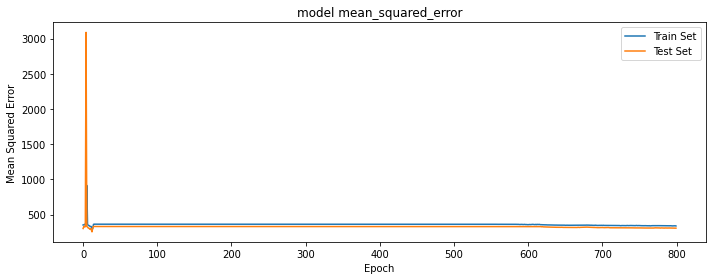

In [ ]:
# Visualizo el entrenamiento
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Test Set'])
plt.tight_layout()
plt.show()

In [69]:
print(history.history['val_mean_absolute_error'][770])

3.5225818157196045


In [9]:
# Guardamos los pesos de la red entrenada
import os
file_name = 'results/weights_lat_3_ssa_two_layer_HH.h5'
folder = os.getcwd().split('/')[:-2]
weights_path = os.path.join('/'.join(folder), file_name)
autoencoder.save_weights(weights_path)

#### Visualizamos los resultados

Veamos cómo son las imágenes generadas por nuestro modelo

In [73]:
# Genero y decodifico imagenes de testeo
encoded_imgs = autoencoder.encoder(scaled_train).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

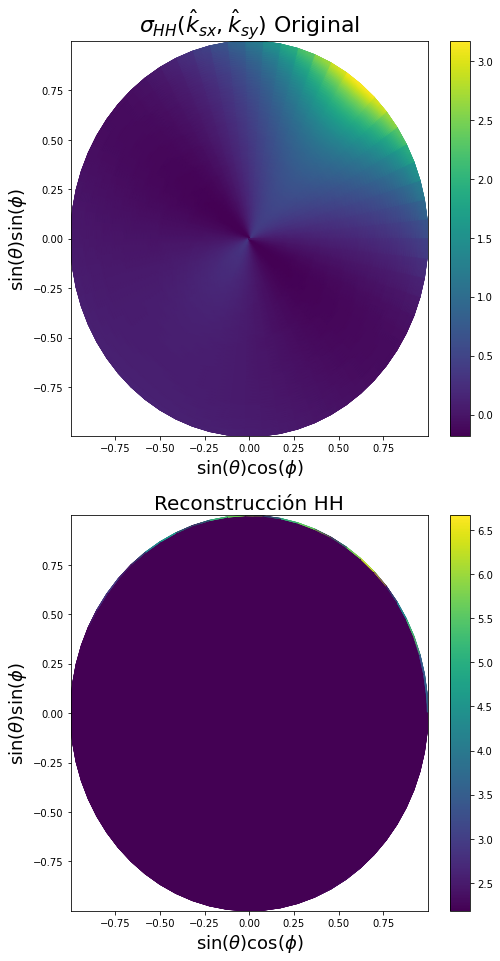

In [76]:
n = 1
pol = {0: "HH", 1: "HV", 2: "VV"}
index = rng.integers(scaled_test.shape[0])

fig = plt.figure(figsize=(8, 16)) 
for i in range(n):
    # Imagen original
    s = scaled_train[index, :, :, 0]
    s_min, s_max = s.min(), s.max()
    ax = plt.subplot(2, n, i + 1)
    c1 = ax.pcolormesh(kx, ky, s, shading = 'gouraud')
    plt.title(f"$\sigma_{{{pol[i]}}}(\hat{{k}}_{{sx}},\hat{{k}}_{{sy}})$ Original", fontsize = 22)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c1, ax=ax)

    # Imagen reconstruida
    s_recons = decoded_imgs[index, :, :, 0]
    s_min, s_max = s_recons.min(), s_recons.max()
    ax = plt.subplot(2, n, i + 1 + n)
    c2 = ax.pcolormesh(kx, ky, s_recons, vmin=s_min,
                       vmax=s_max, shading = 'gouraud')
    plt.title(f"Reconstrucción {pol[i]}", fontsize = 20)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c2, ax=ax)
plt.show()


### Ajuste de hyperparámetros

Vamos a buscar el optimizador, learning rate, inicializador de pesos y batch size optimos de nuestro modelo. Para eso vamos a usar Cross Validation junto con Grid Seach. Usamos GridSearchCV de Sklearn, junto con un wrapper de keras para nuestor modelo: KerasRegresor

In [53]:
from tensorflow.keras import optimizers as opt
from tensorflow.keras.losses import MeanSquaredError

@tf.autograph.experimental.do_not_convert
def create_autoencoder(optimizer='adam',
                       learning_rate=0.0001,
                       beta_momentum=.9,
                       init='glorot_uniform'):
    tf.random.set_seed(123)                   

    # Create optimazer
    select_optimizer = {
        'adam': opt.Adam(learning_rate=learning_rate, beta_1=beta_momentum),
        'RMSProp': opt.RMSprop(learning_rate=learning_rate),
        'sgd': opt.SGD(learning_rate=learning_rate)
                        }
    gradient_descent = select_optimizer.get(optimizer, 'adam')

    # Create and Compile Model
    model = ConvAutoencoder(12, kernel_init=init)
    model.compile(
        optimizer=gradient_descent,
        loss=MeanSquaredError(),
        metrics=['mean_squared_error', 'mean_absolute_error']
        )

    return model

Genero un wrap para usar objetos de keras en scikitlearn

In [45]:
from keras.wrappers.scikit_learn import KerasRegressor

sckit_model = KerasRegressor(
    create_autoencoder, 
    verbose=0, 
    epochs=50, 
    callbacks=[reduce_lr, early_stopping]
    )

Hacemos un Cross Validation sampleando aleatoriamente en la grilla de hyperpárametros.

In [58]:
from sklearn.model_selection import RandomizedSearchCV

l_rate = [0.00005, 0.0001, 0.0005, 0.001, 0.003]
kernel_init = ['glorot_uniform', 'lecun_uniform', 'normal']
batch = [32, 64, 256, 512, 1024]
grad_optimizer = ['adam', 'RMSProp', 'sgd']

hyperparam_grid = {'optimizer': grad_optimizer,
                   'learning_rate': l_rate,
                   'init': kernel_init,
                   'batch_size': batch}

cv = RandomizedSearchCV(sckit_model, 
                        hyperparam_grid,
                        cv=4, 
                        n_iter=15,
                        n_jobs=-1, 
                        random_state=1, 
                        verbose=0,
                        scoring='neg_mean_squared_error' 
                        )


Fiteamos el modelo para cada hyperparametro sampleado 

In [ ]:
tuned_model = cv.fit(scaled_train, scaled_train)

In [52]:
# print results
print(f'Best Score for {tuned_model.best_score_:.4} using {tuned_model.best_params_}')
means = tuned_model.cv_results_['mean_test_score']
stds = tuned_model.cv_results_['std_test_score']
params = tuned_model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Score for -353.1 using {'optimizer': 'adam', 'learning_rate': 0.001, 'init': 'normal', 'batch_size': 32}
mean=-353.1, std=89.91 using {'optimizer': 'adam', 'learning_rate': 0.001, 'init': 'normal', 'batch_size': 32}
mean=-369.1, std=94.38 using {'optimizer': 'RMSProp', 'learning_rate': 5e-05, 'init': 'normal', 'batch_size': 512}
mean=-365.9, std=92.66 using {'optimizer': 'adam', 'learning_rate': 0.0001, 'init': 'glorot_uniform', 'batch_size': 256}
mean=-369.0, std=94.39 using {'optimizer': 'sgd', 'learning_rate': 5e-05, 'init': 'lecun_uniform', 'batch_size': 64}


Generemos un optimizador con decay rate

In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay, PiecewiseConstantDecay

# Define size of mini batch and training epochs
epochs = 1000
batch_size = 1024

# Learning rate decay and steps
initial_learning_rate = 0.0005
final_learning_rate = 0.00005
decay_rate = (initial_learning_rate - final_learning_rate)/epochs
decay_steps = int(scaled_train.shape[0] / batch_size) 
total_steps = decay_steps*epochs

# Learning rate schedule
polynomial_learning_rate = PolynomialDecay(
    initial_learning_rate, 
    decay_steps=total_steps, 
    end_learning_rate=final_learning_rate, 
    power=3,  
    name=None
)

step_learning_rate = PiecewiseConstantDecay(
    boundaries=[bound for bound in range(2000, 16000, 2000)],
    values=[0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00008, 0.00005, 0.00001]
)

# opt=tf.keras.optimizers.SGD(
#     learning_rate=.4, decay=decay_rate, momentum=0.99, nesterov=False, name="SGD", 
#     clipnorm=1)

# Gradient descent optimizer
opt = tf.keras.optimizers.Adam(
    learning_rate=polynomial_learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)


Veamos la pinta del learning rate para cada epoch

In [ ]:
total_steps = decay_steps*epochs
decay = [polynomial_learning_rate(step) for step in range(1, total_steps + 1)]

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
plt.plot(range(1, total_steps + 1), decay)
ax.set_xlabel('Step')
ax.set_ylabel('Inverse Decay')
ax.set_title('Learning rate decay during training')

### Pruebo con KFold Cross Validation


In [ ]:
from sklearn.model_selection import KFold

def log_mapping(tensor):
    """Mapea la distribución de los datos
    a una distribución uniforme"""
    
    # Hago un primer reescaleado
    scaled_tensor = MinMax(tensor)

    # Paso a una escala en DB
    scaled_tensor = np.where(scaled_tensor!=0.0, scaled_tensor, 1e-7)

    return MinMax(10*np.log10(scaled_tensor))

kfold_cv = KFold(n_splits=5)
mse = list()
mae = list()

for train_fold, test_fold in kfold_cv.split(sigma):
    # Transformo los datos
    sigma_train = log_mapping(sigma[train_fold, :, :])
    sigma_test = log_mapping(sigma[test_fold, :, :])

    # Agrego una dimensión más para ingresar a la red
    sigma_train = np.expand_dims(sigma_train, axis=-1)
    sigma_test = np.expand_dims(sigma_test, axis=-1)
    
    # Entreno el modelo
    autoencoder = ConvAutoencoder(8)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])
                    
    history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 100,
            batch_size = 32,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))

    # Guardo los datos 
    mse.append((history.history['mean_absolute_error'],
                history.history['val_mean_absolute_error']))
    mae.append((history.history['mean_squared_error'], 
                history.history['val_mean_squared_error']))
     
    # Elimino el modelo de memoria
    tf.keras.backend.clear_session()
    del autoencoder      

mse = np.vstack(mse)
mae = np.vstack(mae)      

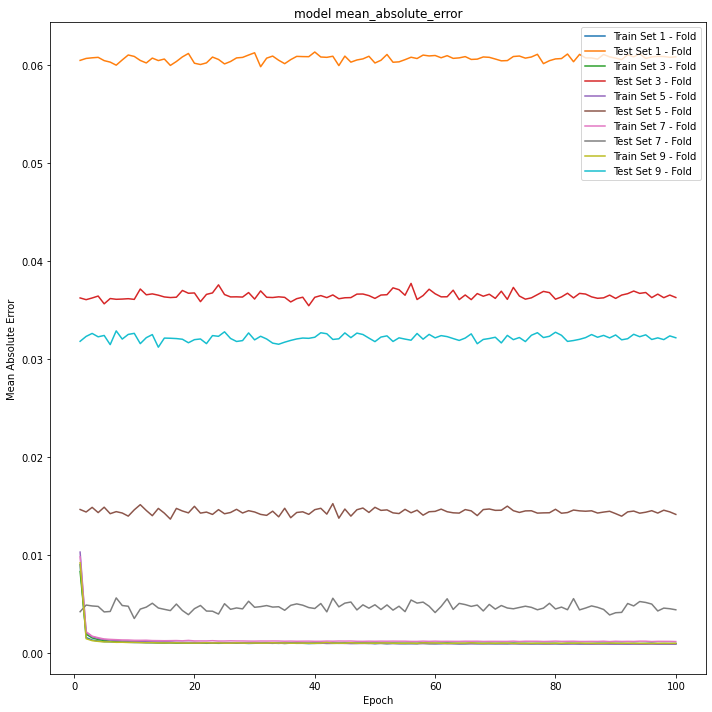

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for idx, error in enumerate(mse):
    f,  = ax.plot(range(1, 101), error)
    if idx%2==0:
        f.set_label(f'Train Set {idx + 1} - Fold')
    else: 
        f.set_label(f'Test Set {idx} - Fold')
    ax.set_title('model mean_absolute_error')
    ax.set_ylabel('Mean Absolute Error')
    ax.set_xlabel('Epoch')
plt.legend()    
plt.tight_layout()    
plt.show()

## Variamos la dimensión del Espacio Latente

In [10]:
# Antes de comenzar limpiamos los pesos del modelo y el grafo de TF
tf.keras.backend.clear_session()
del autoencoder

In [16]:
# Entreno varios autoencoders con distinta dim en espacio latente
min_abs_error, min_sqr_error  = [], []
avg_abs_error, avg_sqr_error = [], []

for lat_dim in range(1, 16):
  autoencoder = ConvAutoencoder(lat_dim)
  autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError(),
                    metrics = ['mean_absolute_error', 'mean_squared_error'])

  # Entreno el modelo
  history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 200,
            batch_size = 30,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))
  
  error_abs = np.array(history.history['val_mean_absolute_error'])
  error_sqr = np.array(history.history['val_mean_squared_error'])

  # Valor mínimo del error
  min_abs_error.append(error_abs.min())
  min_sqr_error.append(error_sqr.min())

  # Valor promedio del error en los ultimos 10 epochs
  avg_abs_error.append(np.mean(error_abs[-50:]))
  avg_sqr_error.append(np.mean(error_sqr[-50:]))

  tf.keras.backend.clear_session()

In [27]:
error_abs = np.array(history.history['val_mean_absolute_error'])
error_sqr = np.array(history.history['val_mean_squared_error'])

# Valor mínimo del error
min_abs_error[13] = error_abs.min()
min_sqr_error[13] = error_sqr.min()

# Valor promedio del error en los ultimos 10 epochs
avg_abs_error[13] = np.mean(error_abs[-50:])
avg_sqr_error[13] = np.mean(error_sqr[-50:])

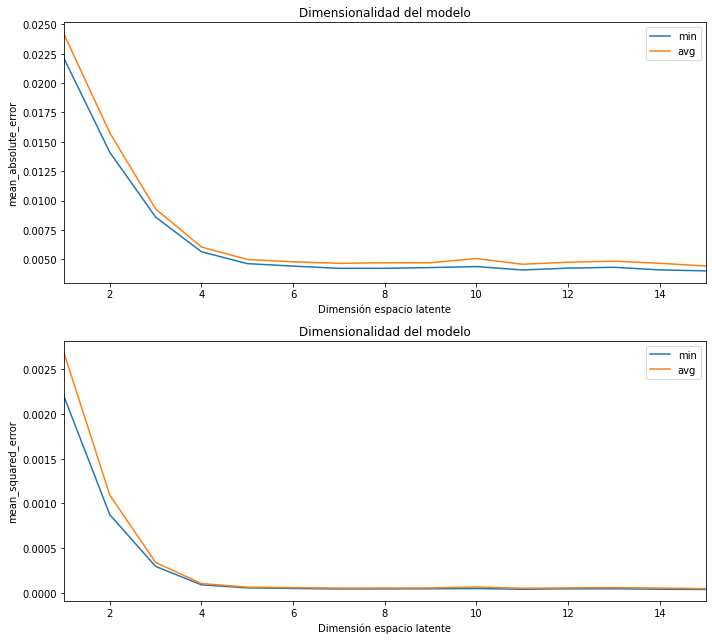

In [28]:
img_name= 'results/costo_SSA_two_layer_2_HH_ngi.png'
img_path = os.path.join('/'.join(folder), img_name)

# Visualizo los errores -  Mean Absolute error
plt.figure(figsize = (10,9))
plt.subplot(2,1,1)
plt.plot(range(1, 16), min_abs_error)
plt.plot(range(1, 16), avg_abs_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_absolute_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
 

# Mean Squared Error
plt.subplot(2,1,2)
plt.plot(range(1, 16), min_sqr_error)
plt.plot(range(1, 16), avg_sqr_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_squared_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
plt.savefig(img_path)
plt.show() 

In [29]:
# Guardo los datos
import pickle
cost_dict = {'MSE': (min_sqr_error, avg_sqr_error), 
             'MAE': (min_abs_error, avg_abs_error)}

path = os.path.join('/'.join(folder), 'results/cost_SSA_two_layer_HH.pkl')             

with open(path, 'wb') as f:
  pickle.dump(cost_dict, f)